# Demo Dove Retrieval

## Import & Setup

In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader

ROOT = Path.cwd()
SRC = ROOT / "src"
if SRC.exists():
    sys.path.insert(0, str(SRC))

from dove.models import DOVEModel
from dove.config import DOVEConfig
from dove.datasets import SkyScriptRetrievalDataset, build_skyscript_transform
from dove.tokenizer import tokenize, SimpleTokenizer


/home/hungvu/miniconda3/envs/hungvv/lib/python3.10/site-packages/torch/cuda/__init__.py:54: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
DATA_ROOT = "data/images"
VAL_CSV = "data/dataframe/SkyScript_val_5K_filtered_by_CLIP_openai.csv"
CHECKPOINT = "runs/dove_skyscript/best.pt"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cuda


## Load Model

In [3]:
ckpt = torch.load(CHECKPOINT, map_location="cpu")
cfg = DOVEConfig.from_dict(ckpt["config"])

tokenizer = SimpleTokenizer()

model = DOVEModel(
    tokenizer.vocab_size,
    embed_dim=cfg.embed_dim,
    image_size=cfg.data.image_size,
    pretrained_backbone=cfg.visual.pretrained_backbone,
    freeze_backbone=cfg.visual.freeze_backbone,
    enable_roam=cfg.fusion.enable_roam,
    word_emb_dim=cfg.text.word_emb_dim,
    gru_hidden=cfg.text.gru_hidden,
    learnable_logit_scale=cfg.loss.use_logit_scale
).to(DEVICE)

model.load_state_dict(ckpt["model"])
model.eval()

print("DOVE loaded successfully")


DOVE loaded successfully


## Load Validation Dataset

In [4]:
tfm = build_skyscript_transform(cfg.data.image_size, train=False)

val_ds = SkyScriptRetrievalDataset(
    DATA_ROOT,
    VAL_CSV,
    cfg.data.caption_field,
    transform=tfm,
    center_box_policy="none",
    on_error="skip"
)

print("Val size:", len(val_ds))


Val size: 5000


## Extract Features

In [9]:
@torch.no_grad()
def extract_all_features(model, dataset):
    image_feats = []
    text_feats = []
    raw_texts = []
    raw_images = []

    for i in tqdm(range(len(dataset))):
        sample = dataset[i]
        if sample is None:
            continue

        img = sample["image"].unsqueeze(0).to(DEVICE)

        # ---- Auto detect caption key ----
        text_key = None
        for k in ["text", "caption", "title_multi_objects", "title"]:
            if k in sample:
                text_key = k
                break

        if text_key is None:
            continue

        text = str(sample[text_key])

        ids = tokenize([text], context_length=77).to(DEVICE)
        lengths = (ids != 0).sum(dim=1)

        out = model(img, ids, lengths)

        image_feats.append(out["image_features"].cpu())
        text_feats.append(out["text_features"].cpu())

        raw_texts.append(text)
        raw_images.append(sample["image"])

    return (
        torch.cat(image_feats),
        torch.cat(text_feats),
        raw_texts,
        raw_images
    )

image_feats, text_feats, raw_texts, raw_images = extract_all_features(model, val_ds)
print("Feature extraction done.")


100%|██████████| 5000/5000 [00:35<00:00, 142.39it/s]


Feature extraction done.


## Đánh giá toàn bộ VAL (Recall@K)

In [10]:
def evaluate_recall(image_feats, text_feats):
    sim = image_feats @ text_feats.t()
    n = sim.size(0)
    gt = torch.arange(n)

    results = {}

    for k in [1,5,10]:
        topk = sim.topk(k, dim=1).indices
        r_i2t = (topk == gt.view(-1,1)).any(dim=1).float().mean().item()

        topk_t = sim.topk(k, dim=0).indices
        r_t2i = (topk_t == gt.view(1,-1)).any(dim=0).float().mean().item()

        results[f"I2T_R@{k}"] = r_i2t
        results[f"T2I_R@{k}"] = r_t2i

    results["Avg_R@1"] = 0.5*(results["I2T_R@1"] + results["T2I_R@1"])
    return results

metrics = evaluate_recall(image_feats, text_feats)
metrics


{'I2T_R@1': 0.7702000141143799,
 'T2I_R@1': 0.670799970626831,
 'I2T_R@5': 0.9422000050544739,
 'T2I_R@5': 0.9398000240325928,
 'I2T_R@10': 0.9769999980926514,
 'T2I_R@10': 0.9810000061988831,
 'Avg_R@1': 0.7204999923706055}

## Dataset Image → Text

In [11]:
def dove_image_to_text_dataset(idx, topk=5):
    sim = image_feats[idx] @ text_feats.t()
    scores, indices = sim.topk(topk)

    plt.figure(figsize=(4,4))
    plt.imshow(raw_images[idx].permute(1,2,0))
    plt.title("Query Image (GT)")
    plt.axis("off")
    plt.show()

    print("Ground Truth:")
    print(raw_texts[idx], "\n")

    for rank,(score,i) in enumerate(zip(scores,indices)):
        print(f"Top {rank+1} | {score.item():.4f}")
        print(raw_texts[i],"\n")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].


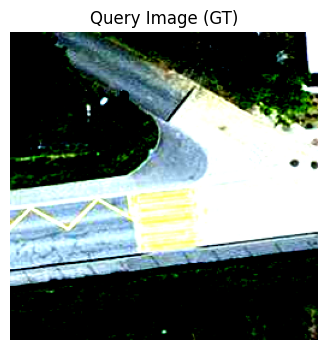

Ground Truth:
a satellite image of road of crossing with crossing of zebra, surrounded by road of residential; road of tertiary 

Top 1 | 0.7797
a satellite image of road of crossing with crossing of zebra, surrounded by road of residential; road of tertiary 

Top 2 | 0.7403
a satellite image of road of crossing with crossing of uncontrolled and crossing markings of zebra, surrounded by road of residential; road of tertiary; road of track 

Top 3 | 0.7182
a satellite image of road of crossing with crossing of zebra, surrounded by road of residential; road of tertiary; road of footway; road of bus stop 

Top 4 | 0.7147
a satellite image of road of bus stop with public transport of platform and shelter and bench, surrounded by road of crossing; road of residential; road of footway; public transport of stop position 

Top 5 | 0.7104
a satellite image of road of crossing with crossing of marked and crossing ref of zebra, surrounded by road of secondary; road of footway 



In [12]:
dove_image_to_text_dataset(10, topk=5)

## Dataset Text → Image

In [13]:
def dove_text_to_image_dataset(idx, topk=5):
    sim = text_feats[idx] @ image_feats.t()
    scores, indices = sim.topk(topk)

    print("Query:", raw_texts[idx], "\n")

    plt.figure(figsize=(15,3))
    for i,(score,img_idx) in enumerate(zip(scores,indices)):
        plt.subplot(1,topk,i+1)
        plt.imshow(raw_images[img_idx].permute(1,2,0))
        plt.title(f"{score.item():.2f}")
        plt.axis("off")
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8610327..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3785625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].


Query: a satellite image of road of crossing with crossing of zebra, surrounded by road of residential; road of tertiary 



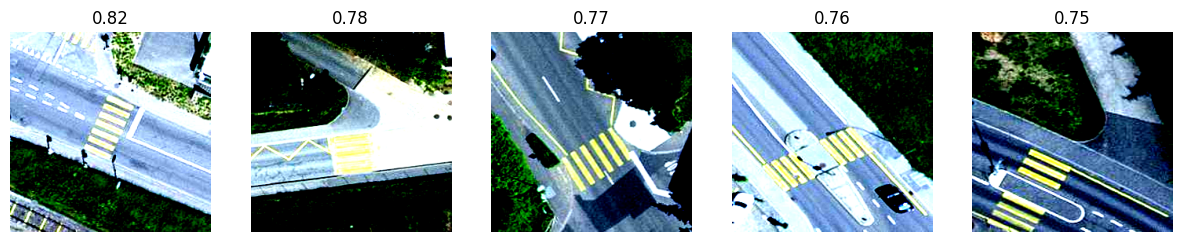

In [14]:
dove_text_to_image_dataset(10)

## Ảnh Tự Tải (Image → Text)

In [15]:
@torch.no_grad()
def custom_image_query(img_path, topk=5):
    img_pil = Image.open(img_path).convert("RGB")
    img_tensor = tfm(img_pil).unsqueeze(0).to(DEVICE)

    dummy_text = tokenize(["dummy"], context_length=77).to(DEVICE)
    dummy_len = (dummy_text != 0).sum(dim=1)

    out = model(img_tensor, dummy_text, dummy_len)
    img_feat = out["image_features"].cpu()

    sim = img_feat @ text_feats.t()
    scores, indices = sim.topk(topk)

    plt.figure(figsize=(4,4))
    plt.imshow(img_pil)
    plt.axis("off")
    plt.title("Custom Query Image")
    plt.show()

    for score,i in zip(scores[0],indices[0]):
        print(f"{score.item():.4f} | {raw_texts[i]}")


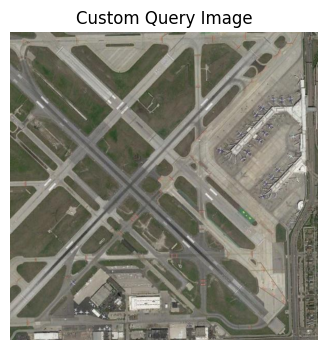

0.7387 | a satellite image of airport of apron, surrounded by road of service; amenity of parking; airport of runway; airport of taxiway
0.6860 | a satellite image of airport of apron, surrounded by airport of aerodrome; surface of asphalt with airport of runway; tunnel of culvert; building of hangar with airport of hangar; airport of taxiway
0.6568 | a satellite image of amenity of prison
0.6544 | a satellite image of landuse of retail, surrounded by road of crossing; building of college; amenity of parking with parking of surface; road of service; highway of primary; highway of primary link; road of unclassified
0.6537 | a satellite image of airport of taxiway, surrounded by landuse of grass; area airport of runway


In [21]:
image_path = "data/benchmark/aid/aid/test/airport_100.jpg"
custom_image_query = custom_image_query(image_path, topk=5)

## Text Tự Nhập (Text → Image)

In [16]:
@torch.no_grad()
def custom_text_query(query, topk=5):
    ids = tokenize([query], context_length=77).to(DEVICE)
    lengths = (ids != 0).sum(dim=1)

    dummy_img = torch.zeros(1,3,cfg.data.image_size,cfg.data.image_size).to(DEVICE)

    out = model(dummy_img, ids, lengths)
    txt_feat = out["text_features"].cpu()

    sim = txt_feat @ image_feats.t()
    scores, indices = sim.topk(topk)

    print("Query:", query, "\n")

    plt.figure(figsize=(15,3))
    for i,(score,img_idx) in enumerate(zip(scores[0],indices[0])):
        plt.subplot(1,topk,i+1)
        plt.imshow(raw_images[img_idx].permute(1,2,0))
        plt.title(f"{score.item():.2f}")
        plt.axis("off")
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3785625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7069099..2.4831376].


Query: a satellite image of road of crossing with crossing of zebra, surrounded by road of residential; road of tertiary 



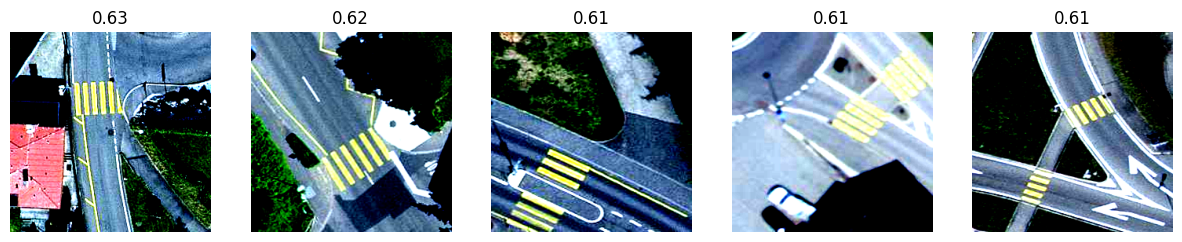

In [20]:
text_query = "a satellite image of road of crossing with crossing of zebra, surrounded by road of residential; road of tertiary"

custom_text_query(text_query, topk=5)